# Steel defect detection

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.preprocessing import *
from steel_segmentation.models.dls import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [ ]:
fastai.__version__

'2.2.3'

In [ ]:
torch.__version__

'1.7.0'

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Jan 26 06:26:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P6000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   28C    P8     9W / 250W |      4MiB / 24449MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print_competition_data(models_dir)

models/ResNet18-Unet-256-stage1.pth
models/ResNet18-Unet-256-stage2.pth
models/ResNet18_kaggle_class.pth
models/ResNet18-Unet-256-stage3.pth
models/.ipynb_checkpoints
models/ResNet34-Unet-128-stage3.pth
models/ResNet18_class.pt
models/kaggle_ResNet18-Unet.pth
models/ResNet34-Unet-128-stage2.pth


## Unet with ResNet18 - Fastai model

In [ ]:
# bs = 4 # 8 gb
bs = 16 # 16 gb
# bs = 32 # 24 gb
szs = (128, 800)

In [ ]:
dls = get_segmentation_dls(bs, szs)

In [ ]:
x, y = dls.one_batch()
type(x), type(y), x.shape, y.shape

(fastai.torch_core.TensorImage,
 fastai.torch_core.TensorMask,
 (4, 3, 256, 1600),
 (4, 256, 1600))

In [ ]:
arch = resnet18

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)

In [ ]:
segmentation_learner.model_dir = models_dir

Loading classifier weights:

In [ ]:
encoder_path = Path("models") / "ResNet18-2_class.pt"

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

In [ ]:
# segmentation_learner.freeze()

### Training

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.4454397387453355e-05)

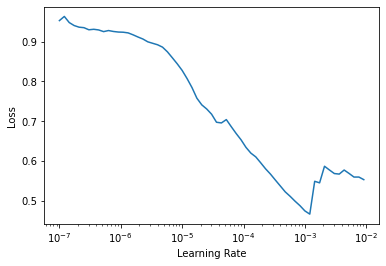

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.077617,0.064304,0.400094,0.864774,07:18
1,0.073341,0.064050,0.395965,0.893417,07:17
2,0.068002,0.061350,0.531013,0.871681,07:14
3,0.055269,0.068252,0.472958,0.880891,07:13
4,0.054680,0.051352,0.545535,0.898572,07:13
5,0.050968,0.049561,0.571110,0.914313,07:12
6,0.048079,0.046953,0.564529,0.914444,07:12
7,0.044176,0.045532,0.641343,0.910027,07:12
8,0.042984,0.044673,0.666555,0.917361,07:12
9,0.039853,0.044556,0.673061,0.915163,07:12


In [ ]:
segmentation_learner.save("ResNet18-Unet-128-stage1")

Path('models/ResNet18-Unet-stage1.pth')

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.047727,0.050091,0.566619,0.915236,07:10
1,0.049110,0.051488,0.614058,0.889133,07:12
2,0.043920,0.045470,0.589829,0.918991,07:12
3,0.042332,0.043937,0.680346,0.920434,07:12
4,0.039790,0.042920,0.683014,0.923082,07:12


In [ ]:
segmentation_learner.save("ResNet18-Unet-128-stage2")

Path('models/ResNet18-Unet-stage2.pth')

### Fine-tuning

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-128-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.042923491448163986,0.6830139631164355,0.9230815172195435]

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=6.309573450380412e-07)

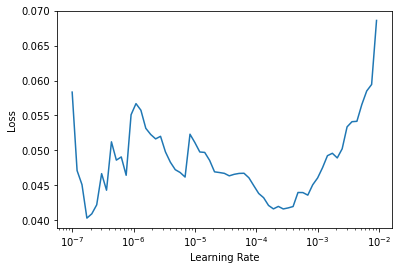

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage3
segmentation_learner.fit_one_cycle(10, lr_max=slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.042608,0.043629,0.685057,0.922095,10:06
1,0.043650,0.044138,0.688359,0.920928,10:05
2,0.042094,0.044083,0.694718,0.919718,10:05
3,0.038842,0.044115,0.684455,0.919441,10:05
4,0.040834,0.042209,0.695586,0.925560,10:06
5,0.038396,0.042617,0.703305,0.929716,10:06
6,0.035363,0.041282,0.713529,0.929295,10:05
7,0.032947,0.041631,0.719175,0.929696,10:05
8,0.034092,0.041418,0.724688,0.930014,10:05
9,0.034992,0.041048,0.727225,0.929578,10:05


In [ ]:
segmentation_learner.save("ResNet18-Unet-128-stage3")

Path('models/ResNet18-Unet-128-stage3.pth')

### Original size

In [ ]:
dls = get_segmentation_dls(4, (256, 1600))

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage3")

In [ ]:
segmentation_learner.validate()

(#3) [0.38744840025901794,0.21576476279658374,0.7342862486839294]

In [ ]:
# to train

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=1.0964781722577754e-06)

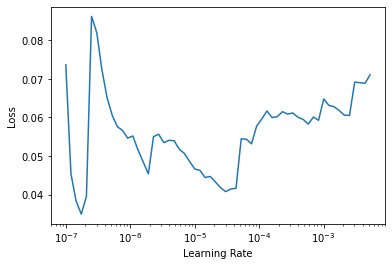

In [ ]:
segmentation_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(7, lr_max=slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.049452,0.043746,0.731827,0.925984,42:37
1,0.060002,0.045127,0.704314,0.921602,42:46


In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage4")

## Unet with ResNet34 - Fastai model

In [ ]:
# bs = 8 # 8 gb
# bs = 16 # 16 gb
bs = 32 # 24 gb
szs = (128, 800)

In [ ]:
dls = get_segmentation_dls(bs, szs)

In [ ]:
x, y = dls.one_batch()
type(x), type(y), x.shape, y.shape

(fastai.torch_core.TensorImage,
 fastai.torch_core.TensorMask,
 (32, 3, 128, 800),
 (32, 128, 800))

In [ ]:
encoder_path = Path("models") / "ResNet34_class.pt"

In [ ]:
arch = resnet34

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)

In [ ]:
segmentation_learner.model_dir = models_dir

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

### Training

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=6.30957365501672e-05)

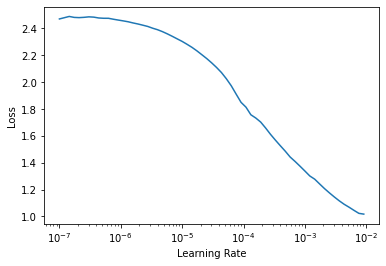

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time


In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage1")

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-128-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.043838582932949066,0.6954206076374241,0.9211909770965576]

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=6.309573450380412e-07)

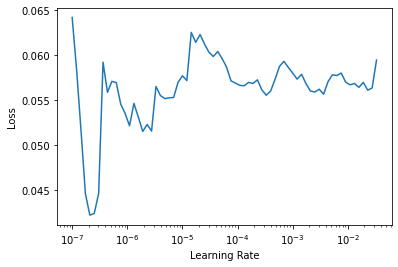

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# bs = 8 # 8 gb
# bs = 16 # 16 gb
bs = 32 # 24 gb
szs = (256, 1600)

In [ ]:
dls = get_segmentation_dls(bs//2, szs)

In [ ]:
segmentation_learner.fit_one_cycle(10, lr_max=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.058628,0.044736,0.679471,0.920276,07:32
1,0.056991,0.044621,0.688327,0.919616,07:34
2,0.049047,0.044893,0.689537,0.921357,07:34
3,0.050807,0.044372,0.691909,0.920939,07:34
4,0.050193,0.044733,0.695227,0.918694,07:34
5,0.047631,0.043800,0.690386,0.921308,07:34
6,0.045325,0.043778,0.702775,0.921402,07:34
7,0.045274,0.043894,0.696209,0.921499,07:34
8,0.044785,0.043595,0.705300,0.921908,07:34
9,0.047181,0.043621,0.702583,0.922402,07:34


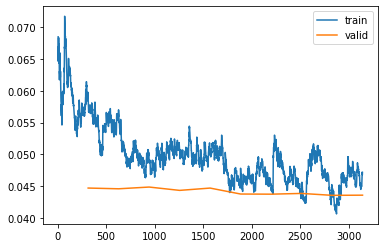

In [ ]:
segmentation_learner.recorder.plot_loss()

In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage2.5")

Path('models/ResNet34-Unet-128-stage2.5.pth')

# Old

Parte di codice con cui ho cercato di costruire un DataLoader con tutte le immagini difettose e solo immagini con patterns per gli *hard negatives*. 

In [ ]:
def check_img_paths(name: str):
    path = train_path / name    
    return path.is_file()

for num, img_name in enumerate(pattern_imgs):
    if not check_img_paths(img_name):
        print(f"Img {img_nameme}, num {num} not found!")

In [ ]:
train_imgs_df = train["ImageId"].drop_duplicates().to_frame()
print(train_imgs_df.shape)
train_imgs_df.isna().any()

(6666, 1)


ImageId    False
dtype: bool

In [ ]:
pattern_imgs_df = pd.Series(pattern_imgs, name="ImageId").drop_duplicates().to_frame()
print(pattern_imgs_df.shape)
pattern_imgs_df.isna().any()

(598, 1)


ImageId    False
dtype: bool

In [ ]:
nohardneg_df = pd.merge(pattern_imgs_df, train_imgs_df, how='outer')
print(nohardneg_df.info())
# nohardneg_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7261 entries, 0 to 7260
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  7261 non-null   object
dtypes: object(1)
memory usage: 113.5+ KB
None


In [ ]:
common_imgs = pd.merge(pattern_imgs_df, train_imgs_df, how='inner')
common_imgs["ImageId"] = common_imgs["ImageId"].drop_duplicates()
common_imgs.head()

,ImageId
0,306415665.jpg
1,6ee81c40c.jpg
2,a9f605949.jpg


In [ ]:
# img_path = train_path/"306415665.jpg"
# Image.open(img_path)

In [ ]:
# img_path = train_path/"6ee81c40c.jpg"
# Image.open(img_path)

In [ ]:
# img_path = train_path/"a9f605949.jpg"
# Image.open(img_path)

In [ ]:
# bs = 16 # 8 gb
bs = 16 # 16 gb
size = (128,800)

In [ ]:
dls = get_df_dls(train_df=nohardneg_df, bs=bs, size=size)

In [ ]:
len(dls.train.dataset), len(dls.valid.dataset)

(5809, 1452)

In [ ]:
# dls.show_batch(figsize=(40,40))